# TSSL Lab 1 - Autoregressive models

We load a few packages that are useful for solvign this lab assignment.

In [1]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm  # Used for solving linear regression problems
from sklearn.neural_network import MLPRegressor # Used for NAR model

from tssltools_lab1 import acf, acfplot # Module available in LISAM - Used for plotting ACF

## 1.1 Loading, plotting and detrending data

In this lab we will build autoregressive models for a data set corresponding to the Global Mean Sea Level (GMSL) over the past few decades. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

**Q1**: Load the data and plot the GMSL versus time. How many observations are there in total in this data set?

_Hint:_ With pandas you can use the function `pandas.read_csv` to read the csv file into a data frame. Plotting the time series can be done using `pyplot`. Note that the sea level data is stored in the 'GMSL' column and the time when each data point was recorded is stored in the column 'Year'.

**A1**: There are a total of 1083 observations in the dataset

(1083, 12)


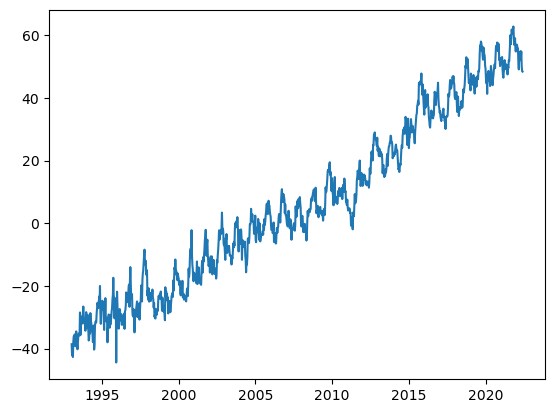

In [85]:
data = pandas.read_csv('sealevel.csv')

print(np.shape(data))

##print(data)

plotdata = data[["Year","GMSL"]]

##print(plotdata)

plt.plot('Year', 'GMSL', data=plotdata)

**Q2**: The data has a clear upward trend. Before fitting an AR model to this data need to remove this trend. Explain, using one or two sentences, why this is necessary.

**A2**: We need to remove this trend because the time series data needs to be stationary for fitting an AR mdoel. For an AR model we have a few different conditions that must be meet: 1: var(t) < inf 2: mu(t) = constant 3: The autocovariate function depends only on the time lag. 

**Q3** Detrend the data following these steps:
1. Fit a straight line, $\mu_t=\theta_0 + \theta_1 u_t $ to the data based on the method of least squares. Here, $u_t$ is the time point when obervation $t$ was recorded.

    _Hint:_ You can use `lm.LinearRegression().fit(...)` from scikit-learn. Note that the inputs need to be passed as a 2D array.

    Before going on to the next step, plot your fitted line and the data in one figure.


2. Subtract the fitted line from $y_t$ for the whole data series and plot the deviations from the straight line.

**From now, we will use the detrended data in all parts of the lab.**

_Note:_ The GMSL data is recorded at regular time intervals, so that $u_{t+1} - u_t = $ const. Therefore, you can just as well use $t$ directly in the linear regression function if you prefer, $\mu_t=\theta_0 + \theta_1 t $.

**A3:**

(1083, 1)


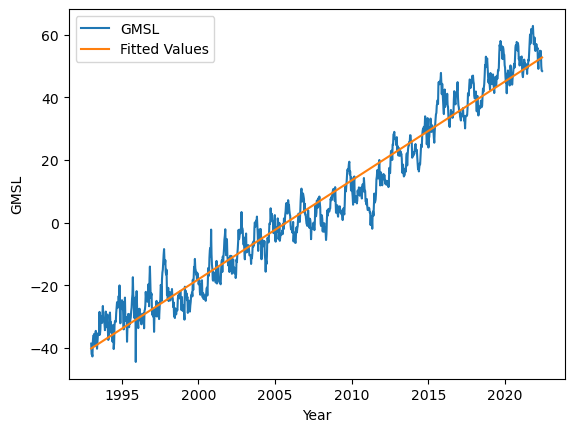

In [3]:
##np.shape(plotdata)

X = plotdata[['Year']]
Y = plotdata[['GMSL']]

print(np.shape(X))

lin_model = lm.LinearRegression().fit(X,Y)

lin_predictions = lin_model.predict(X)

##print(lin_predictions)

plt.plot('Year', 'GMSL', data=plotdata)
plt.plot(plotdata['Year'], lin_predictions, label = "Fitted Values")
plt.xlabel("Year")
plt.ylabel("GMSL")
plt.legend()
plt.show()

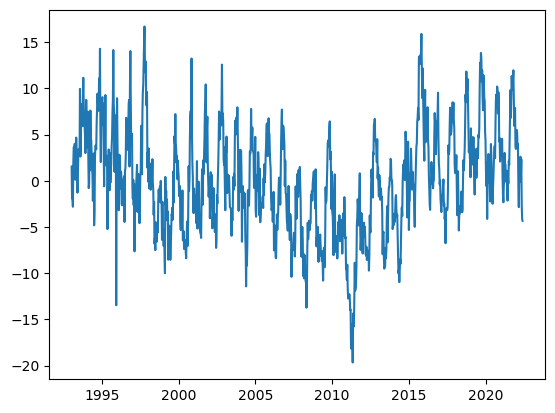

In [4]:
Detrend_Y = Y - lin_predictions

plt.plot(plotdata['Year'], Detrend_Y)

#print(np.shape(Detrend_Y))

**Q4:** Split the (detrended) time series into training and validation sets. Use the values from the beginning up to the 700th time point (i.e. $y_t$ for $t=1$ to $t=700$) as your training data, and the rest of the values as your validation data. Plot the two data sets.

_Note:_ In the above, we have allowed ourselves to use all the available data (train + validation) when detrending. An alternative would be to use only the training data also when detrending the model. The latter approach is more suitable if, either:
* we view the linear detrending as part of the model choice. Perhaps we wish to compare different polynomial trend models, and evaluate their performance on the validation data, or
* we wish to use the second chunk of observations to estimate the performance of the final model on unseen data (in that case it is often referred to as "test data" instead of "validation data"), in which case we should not use these observations when fitting the model, including the detrending step.

In this laboration we consider the linear detrending as a predetermined preprocessing step and therefore allow ourselves to use the validation data when computing the linear trend.

**A4:**

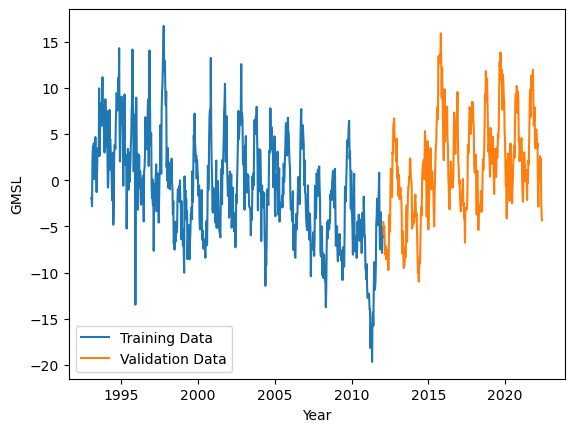

382


In [28]:
X_train = X[1:701]
Y_train = Detrend_Y[1:701]

X_valid = X[701:]
Y_valid = Detrend_Y[701:]

#Plot training data

plt.plot(X_train, Y_train, label = "Training Data")
plt.plot(X_valid, Y_valid, label = "Validation Data")
plt.xlabel("Year")
plt.ylabel("GMSL")
plt.legend()
plt.show()

#print(len(X_valid))

## 1.2 Fit an autoregressive model
We will now fit an AR$(p)$ model to the training data for a given value of the model order $p$.

**Q5**: Create a function that fits an AR$(p)$ model for an arbitrary value of p. Use this function to fit a model of order $p=10$ to the training data and write out (or plot) the coefficients.

_Hint:_ Since fitting an AR model is essentially just a standard linear regression we can make use of `lm.LinearRegression().fit(...)` similarly to above. You may use the template below and simply fill in the missing code.

**A5:**

In [6]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = len(y) # <COMPLETE THIS LINE>
    
    # Construct the regression matrix
    Phi = np.zeros((n-p,p)) # <COMPLETE THIS LINE>
    for j in range(p):
        Phi[:,[j]] = y[p-j-1:n-j-1] # <COMPLETE THIS LINE>
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)    

    return regr.coef_

In [7]:
#fitting AR(10)

#j=5
#n = len(Y_train)
#ty = np.values(Y_train[p-j-1:n-j-1])
#print(np.shape(ty))

p = 10
theta = fit_ar(Y_train, p)
print(theta)


[[ 0.62906455  0.1229288   0.12527788  0.1768164  -0.02290915 -0.07095943
  -0.05663896  0.04786988 -0.09028994  0.02361855]]


**Q6:** Next, write a function that computes the one-step-ahead prediction of your fitted model. 'One-step-ahead' here means that in order to predict $y_t$ at $t=t_0$, we use the actual values of $y_t$ for $t<t_0$ from the data. Use your function to compute the predictions for both *training data* and *validation data*. Plot the predictions together with the data (you can plot both training and validation data in the same figure). Also plot the *residuals*.

_Hint:_ It is enought to call the predict function once, for both training and validation data at the same time.

**A6:**

In [8]:
def predict_ar_1step(theta, y_target):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n) 
    """

    n = len(y_target)
    p = len(np.transpose(theta))
    
    # Number of steps in prediction
    m = n-p
    y_pred = np.zeros(m)
    
    for i in range(m):
        # <COMPLETE THIS CODE BLOCK>
        y_pred[i] = np.dot(np.flip(theta),y_target[i:i+p]) # <COMPLETE THIS LINE>
        
    return y_pred

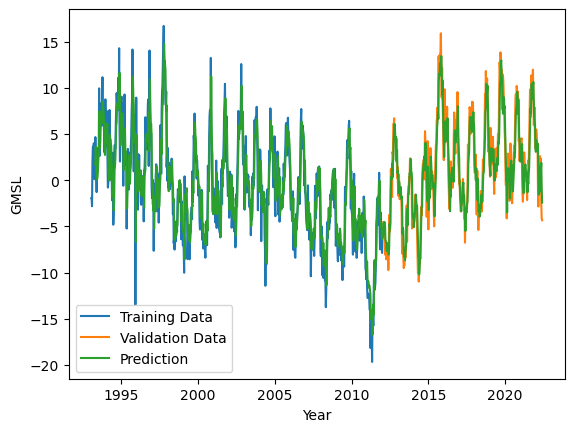

In [9]:
#len(theta)

predict_final = predict_ar_1step(theta, Detrend_Y)

plt.plot(X_train, Y_train, label = "Training Data")
plt.plot(X_valid, Y_valid, label = "Validation Data")
plt.plot(X[p:], predict_final, label = "Prediction" )
plt.xlabel("Year")
plt.ylabel("GMSL")
plt.legend()
plt.show()


(382, 1)


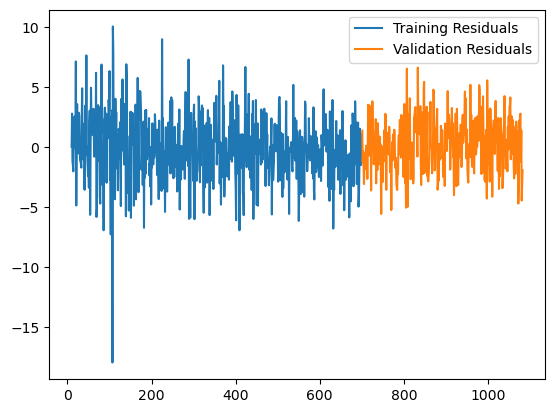

In [29]:
#plot the residuals

#print(np.shape(Detrend_Y[p:]))
#print(np.shape(predict_final))

predict_final = predict_final.reshape(len(Detrend_Y)-p,1)
resids = Detrend_Y[p:] - predict_final
#print(np.shape(resids[701-p:]))

plt.plot(resids[:701-p], label = "Training Residuals")
plt.plot(resids[701-p:], label = "Validation Residuals")
plt.legend()
plt.show()

**Q7:** Compute and plot the autocorrelation function (ACF) of the *residuals* only for the *validation data*. What conclusions can you draw from the ACF plot?

_Hint:_ You can use the function `acfplot` from the `tssltools` module, available on the course web page.

**A7:** Looking at the ACFplot we can ascertain that the AR(10) is not a good fit for the given data because there is significant deviation of the several early ACF values from 0 and quite many actually lie outside the 95% confidence band. A good model should have the emperical ACF values -> 0 resembling an ACF plot of white noise (as shown in lecture 2d), since the residuals according to the model assumptions are gaussian.

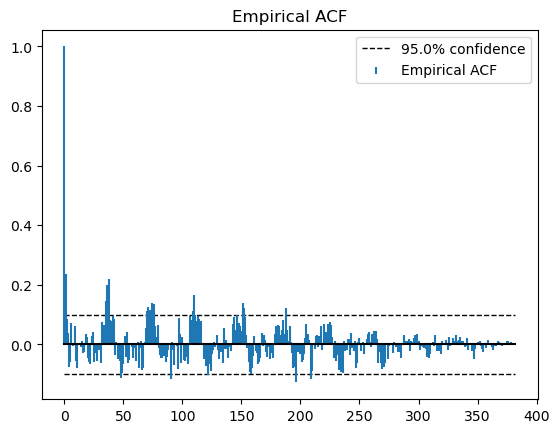

In [22]:
valid_resids = resids[700-p:]
valid_resids = np.squeeze(valid_resids)

acfplot(valid_resids)

## 1.3 Model validation and order selection
Above we set the model order $p=10$ quite arbitrarily. In this section we will try to find an appropriate order by validation.

**Q8**: Write a loop in which AR-models of orders from $p=2$ to $p=150$ are fitted to the data above. Plot the training and validation mean-squared errors for the one-step-ahead predictions versus the model order.

Based on your results:
- What is the main difference between the changes in training error and validation error as the order increases? 
- Based on these results, which model order would you suggest to use and why?

_Note:_ There is no obvious "correct answer" to the second question, but you still need to pick an order an motivate your choice!


**A8:** While the Training MSE keeps reducing with higher model order, there is a sharp drop at approx p = 110, where the training error becomes lower than the validation error suggesting overfitting since the training error continues to fall while the validation error continues to grow for higher model order. The validation error is lowest in the range of 40<p<80 before it starts climbing again. Suggesting that the model starts overfitting around p = 70.

There is not much gain in validation accuracy for models with higher order than something in the neighbourhood of p = 45, we still chose to check for the lowest validation error model order and found it to be **p=52**. Since, this is neither too complex and the training error is also not very high, we suggest this choice in proceeding.

In [31]:
TrainMSE = np.zeros(149)
ValidMSE = np.zeros(149)

for i in range(2,151):
    theta = fit_ar(Y_train, i)
    predict_y = predict_ar_1step(theta, Detrend_Y)
    
    resid_loop = np.squeeze(Detrend_Y[i:]) - predict_y
    
    ValidMSE[i-2] = np.sum((resid_loop[701-i:]**2 ))/ len(resid_loop[701-i:])

    TrainMSE[i-2] = np.sum((resid_loop[:701-i]**2)) / len(resid_loop[:701-i])


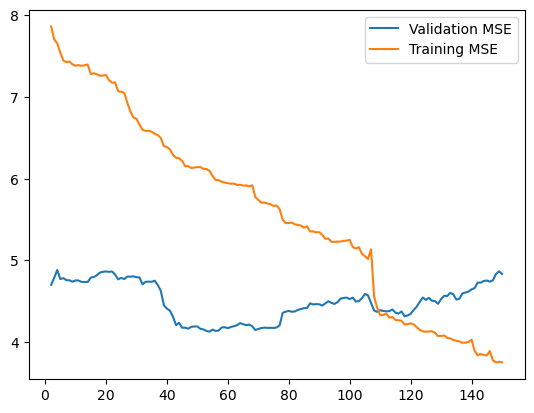

In [32]:
X_axis = range(2,151)
plt.plot(X_axis, ValidMSE, label = "Validation MSE")
plt.plot(X_axis, TrainMSE, label = "Training MSE")
plt.legend()

In [43]:
print(np.where(ValidMSE == np.amin(ValidMSE)))

(array([52], dtype=int64),)


**Q9:** Based on the chosen model order, compute the residuals of the one-step-ahead predictions on the *validation data*. Plot the autocorrelation function of the residuals. What conclusions can you draw? Compare to the ACF plot generated above for p=10.

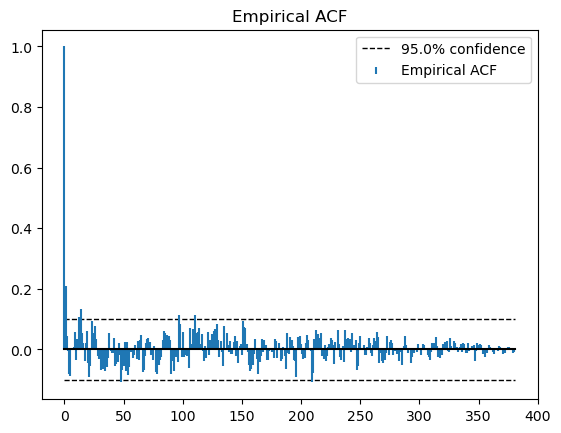

In [44]:
p = 52
theta52 = fit_ar(Y_train, p)
predict_y_52 = predict_ar_1step(theta52, Detrend_Y)
resid_52 = np.squeeze(Detrend_Y[p:]) - predict_y_52
Valid_resid_52 = resid_52[701-p:]
acfplot(Valid_resid_52)

**A9:** There is significant improvement in the acfplot for AR(52) vs what we saw earlier for AR(10). It can be seen from the plot that the emperical ACF values are mostly withing the 95% confidence bands, and there is also convergence to zero mean over higher values of n. It still is far from resembling gaussian noise, but it fares better than AR(10).

## 1.4 Long-range predictions
So far we have only considered one-step-ahead predictions. However, in many practical applications it is of interest to use the model to predict further into the future. For intance, for the sea level data studied in this laboration, it is more interesting to predict the level one year from now, and not just 10 days ahead (10 days = 1 time step in this data).

**Q10**: 
Write a function that simulates the value of an AR($p$) model $m$ steps into the future, conditionally on an initial sequence of data points. Specifically, given $y_{1:n}$ with $n\geq p$ the function/code should predict the values

\begin{align}
    \hat y_{t|n} &= \mathbb{E}[y_{t} | y_{1:n}], & t&=n+1,\dots,n+m.
\end{align}

Use this to predict the values for the validation data ($y_{701:997}$) conditionally on the training data ($y_{1:700}$) and plot the result.

_Hint:_ Use the pseudo-code derived at the first pen-and-paper session.

**A10:** On making m-step ahead predictions we check the MSE for validation data, and see that our initial choice of model order = 52 was close to order for the which the lowest MSE is achieved here for making predictions. We proceed with p=45 and simulate m-step predictions again. 

As we move forward in time and keep replacing actual values with simulated values for future predictions we keep moving away from actual data. Thus, the quality of predictions keep decreasing the further we move forward into the future.


In [79]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """

    p = len(theta)    
    y_sim = np.zeros(m)
    phi = np.flip(y[-p:].copy()) # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point

    for i in range(m):
        y_sim[i] = np.dot(theta, phi) # next step prediction
        # append prediction to preceding p-1 observations while removing the oldest observation for next prediction
        phi = np.concatenate([y_sim[i:i+1], phi[:-1]])
    
    return y_sim
    

Text(0.5, 1.0, 'Validation MSE for m-step')

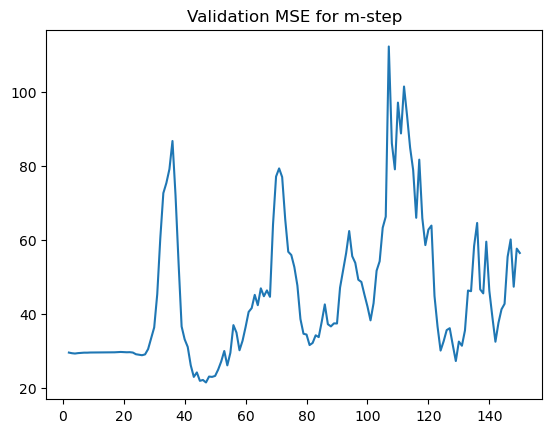

In [82]:
#check the validation error for m-step predictions for all mdoel orders between 2-150
Valid_MSE_sim = np.zeros(149)

for i in range(2,151):
    theta = fit_ar(Y_train, i) #fit AR(p) model
    
    #get m-step predictions on validation data
    predict_y = simulate_ar(np.squeeze(Y_train), np.squeeze(np.transpose(theta)), m = len(Y_valid))
    
    #validation residuals
    resid_loop = np.squeeze(Y_valid) - predict_y
    
    #MSE
    Valid_MSE_sim[i-2] = np.sum((resid_loop**2 ))/ len(resid_loop)
    
plt.plot(X_axis, Valid_MSE_sim)
plt.title("Validation MSE for m-step")

In [83]:
#choose lowest validation MSE for new model order
print(np.where(Valid_MSE_sim == np.amin(Valid_MSE_sim)))

(array([45], dtype=int64),)


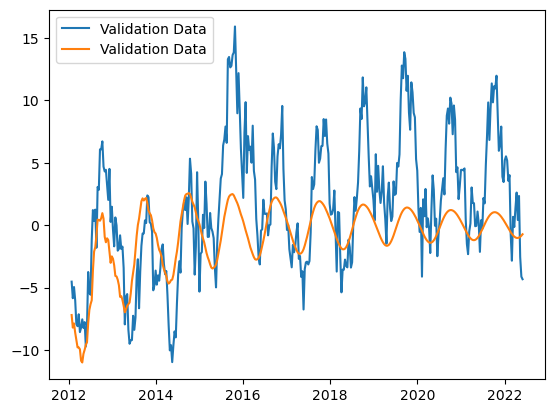

In [84]:
# new choice of model order
p = 45
theta = fit_ar(Y_train, 45)
Y_valid_predictions_45 = simulate_ar(np.squeeze(Y_train), np.squeeze(np.transpose(theta)), m = len(Y_valid))

plt.plot(X_valid, Y_valid, label = "Validation Data")
plt.plot(X_valid, Y_valid_predictions_45, label = "Validation Predictions")
plt.legend()


**Q11:** Using the same function as above, try to simulate the process for a large number of time steps (say, $m=2000$). You should see that the predicted values eventually converge to a constant prediction of zero. Is this something that you would expect to see in general? Explain the result.

**A11:** When we detrended the data during preprocessing, we can see that the mean of the data is approx 0. with larger values of m such as in this case, the more we use simulated values for future predictions, the results will tend to converge around the mean which in this case is 0. Another contributing factor is that in the code for the AR_simulation, we have not added any gaussian noise to the prediction, hence, the convergence to the mean over time.

Text(0.5, 1.0, '2000-step predictions')

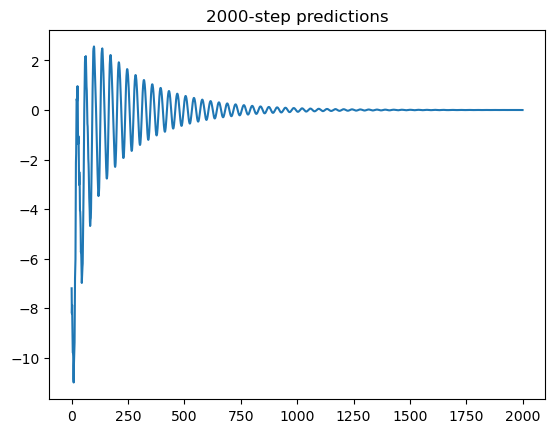

In [88]:
# 2000-step predictions
Y_valid_predictions_2000 = simulate_ar(np.squeeze(Y_train), np.squeeze(np.transpose(theta)), m = 2000)

plt.plot(Y_valid_predictions_2000)
plt.title("2000-step predictions")

## 1.5 Nonlinear AR model
 In this part, we switch to a nonlinear autoregressive (NAR) model, which is based on a feedforward neural network. This means that in this model the recursive equation for making predictions is still in the form $\hat y_t=f_\theta(y_{t-1},...,y_{t-p})$, but this time $f$ is a nonlinear function learned by the neural network. Fortunately almost all of the work for implementing the neural network and training it is handled by the `scikit-learn` package with a few lines of code, and we just need to choose the right structure, and prepare the input-output data.   

**Q12**: Construct a NAR($p$) model with a feedforward (MLP) network, by using the `MLPRegressor` class from `scikit-learn`. Set $p$ to the same value as you chose for the linear AR model above. Initially, you can use an MLP with a single hidden layer consisting of 10 hidden neurons. 
Train it using the same training data as above and plot the one-step-ahead predictions as well as the residuals, on both the training and validation data. 

_Hint:_ You will need the methods `fit` and `predict` of `MLPRegressor`. Read the user guide of `scikit-learn` for more details. Recall that a NAR model is conceptuall very similar to an AR model, so you can reuse part of the code from above.

**A12:**

D:\Anaconda\envs\tssl\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


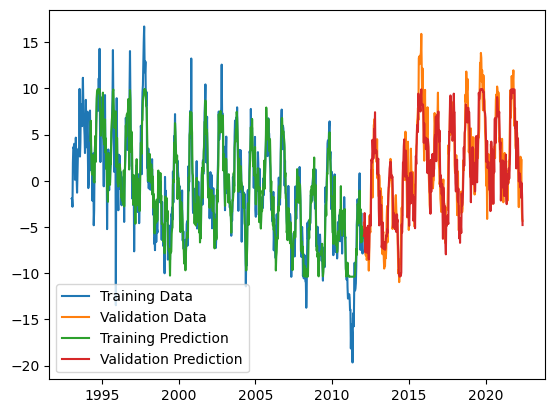

In [98]:
#set p to chosen value from earlier
p = 45

#MLP model
MLP = MLPRegressor(hidden_layer_sizes = (10,),
                   activation = 'tanh',
                   solver = 'sgd',
                   max_iter = 200)

#training points
n_train = len(Y_train)

# Construct the regression matrix
Phi_train = np.zeros((n_train-p,p)) 
for j in range(p):
    Phi_train[:,[j]] = Y_train[p-j-1:n_train-j-1] 
    
# Drop the first p values from the target vector y
yy_train = np.squeeze(Y_train[p:])  # yy = (y_{t+p+1}, ..., y_n)

#fit MLP NN
MLP.fit(X=Phi_train, y = yy_train)

#1-step ahead prediction
Y_predict_train = MLP.predict(Phi_train)

#validation points
Y_valid_new = np.concatenate([Y_train[n_train-p:], Y_valid])
n_valid = len(Y_valid_new)

# Construct the regression matrix
Phi_valid = np.zeros((n_valid-p,p)) 
for j in range(p):
    Phi_valid[:,[j]] = Y_valid_new[p-j-1:n_valid-j-1] 
    
#1-step ahead prediction
Y_predict_valid = MLP.predict(Phi_valid)

#residuals
res_train = np.squeeze(Y_train[p:]) - Y_predict_train
res_valid = np.squeeze(Y_valid) - Y_predict_valid

#plot
plt.plot(X_train, Y_train, label = "Training Data")
plt.plot(X_valid, Y_valid, label = "Validation Data")
plt.plot(X_train[p:], Y_predict_train, label = "Training Prediction")
plt.plot(X_valid, Y_predict_valid, label = "Validation Prediction")
plt.legend()





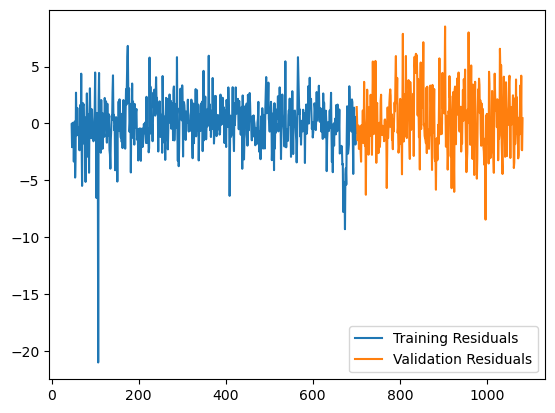

In [99]:
plt.plot(res_train, label = "Training Residuals")
plt.plot(res_valid, label = "Validation Residuals")
plt.legend()
plt.show()

**Q13:** Try to expirement with different choices for the hyperparameters of the network (e.g. number of hidden layers and units per layer, activation function, etc.) and the optimizer (e.g. `solver` and `max_iter`).

Are you satisfied with the results? Why/why not? Discuss what the limitations of this approach might be.

**A13:** Increasing the number of hidden layers and neurons, led to overfitting as expected. The initial experiment with lower max_iterations, did not lead to convergence so we experimented with atleast 500 iterations. But increasing the iterations beyond a certain level also led to overfitting. Generally, the use of tanh as activation function led to more overfitting on training data and larger validation residuals.

Overall, we were not very satisfied with the results of our experiments as the validation predictions were very off and we did not see better results than AR models. Overfitting due to NNs was expected and resulted in models that were not good for prediction on unseen data.

We felt that one of the contributing factors to unsatisfactory results was that this data is very small. Our training data was still only 700 points. Thus, for better predictions from MLP, we should evaluate this approach on larger data sets.

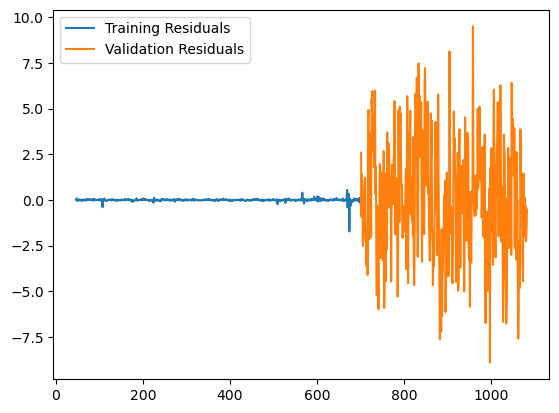

In [114]:
#MLP model
MLP = MLPRegressor(hidden_layer_sizes = (50, 50),
                   activation = 'tanh',
                   solver = 'adam',
                   max_iter = 500)

#training points
n_train = len(Y_train)

# Construct the regression matrix
Phi_train = np.zeros((n_train-p,p)) 
for j in range(p):
    Phi_train[:,[j]] = Y_train[p-j-1:n_train-j-1] 
    
# Drop the first p values from the target vector y
yy_train = np.squeeze(Y_train[p:])  # yy = (y_{t+p+1}, ..., y_n)

#fit MLP NN
MLP.fit(X=Phi_train, y = yy_train)

#1-step ahead prediction
Y_predict_train = MLP.predict(Phi_train)

#validation points
Y_valid_new = np.concatenate([Y_train[n_train-p:], Y_valid])
n_valid = len(Y_valid_new)

# Construct the regression matrix
Phi_valid = np.zeros((n_valid-p,p)) 
for j in range(p):
    Phi_valid[:,[j]] = Y_valid_new[p-j-1:n_valid-j-1] 
    
#1-step ahead prediction
Y_predict_valid = MLP.predict(Phi_valid)

#residuals
res_train = np.squeeze(Y_train[p:]) - Y_predict_train
res_valid = np.squeeze(Y_valid) - Y_predict_valid

plt.plot(res_train, label = "Training Residuals")
plt.plot(res_valid, label = "Validation Residuals")
plt.legend()
plt.show()

D:\Anaconda\envs\tssl\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


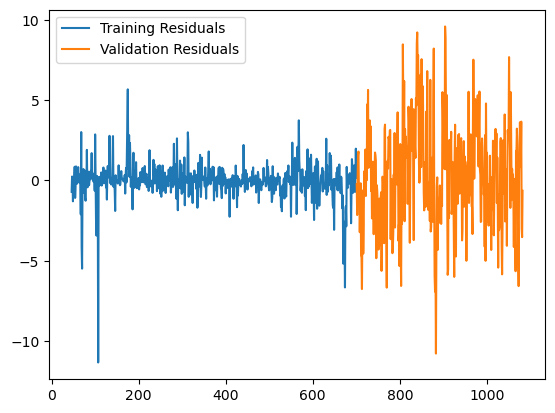

In [122]:
#MLP model
MLP = MLPRegressor(hidden_layer_sizes = (20,10),
                   activation = 'tanh',
                   solver = 'adam',
                   max_iter = 500)

#training points
n_train = len(Y_train)

# Construct the regression matrix
Phi_train = np.zeros((n_train-p,p)) 
for j in range(p):
    Phi_train[:,[j]] = Y_train[p-j-1:n_train-j-1] 
    
# Drop the first p values from the target vector y
yy_train = np.squeeze(Y_train[p:])  # yy = (y_{t+p+1}, ..., y_n)

#fit MLP NN
MLP.fit(X=Phi_train, y = yy_train)

#1-step ahead prediction
Y_predict_train = MLP.predict(Phi_train)

#validation points
Y_valid_new = np.concatenate([Y_train[n_train-p:], Y_valid])
n_valid = len(Y_valid_new)

# Construct the regression matrix
Phi_valid = np.zeros((n_valid-p,p)) 
for j in range(p):
    Phi_valid[:,[j]] = Y_valid_new[p-j-1:n_valid-j-1] 
    
#1-step ahead prediction
Y_predict_valid = MLP.predict(Phi_valid)

#residuals
res_train = np.squeeze(Y_train[p:]) - Y_predict_train
res_valid = np.squeeze(Y_valid) - Y_predict_valid

plt.plot(res_train, label = "Training Residuals")
plt.plot(res_valid, label = "Validation Residuals")
plt.legend()
plt.show()